In [487]:
#importacion general de librerias y de visualizacion (matplotlib y seaborn)
%matplotlib notebook
%config IPCompleter.greedy=True
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer


#pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 10
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


In [488]:
train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')

train_df['location'].fillna(value='sin location', inplace=True)
train_df['keyword'].fillna(value='sin keyword', inplace=True)

train_df['text'] = train_df.text.str.lower()
train_df['text'] = train_df.text.str.replace('%20', ' ')

train_df['keyword'] = train_df.keyword.str.lower()
train_df['keyword'] = train_df.keyword.str.replace('%20', ' ')

train_df['location'] = train_df.location.str.lower()
train_df['location'] = train_df.location.str.replace('%20', ' ')

# Funciones Generales

In [489]:

NOTICIEROS = ['cnn', 'bbc', 'reuters', 'blomberg', 'herald', 'today', 'herald', 'abc', 'fox', 'cbs', \
            'yorker', 'daily', 'financial', 'guardian', 'sun', 'observer', 'five', 'jazeera', 'news', 'live']

PAIS_DESASTRES = ['usa', 'united states', 'canada', 'island', 'japan', 'nigeria', 'turkey', 'saudi', \
                  'malaysia']

CIUDAD_DESASTRES = ['california', 'new york', 'nyc', 'hawaii', 'hiroshima', 'fukushima', 'calgary']
 
DESASTRES_CONOCIDOS = ['mh370', 'air', 'huracan', 'fire', 'water', 'kill', 'disaster', 'suicide', 'police', 'people', \
                      'flood', 'police', 'home', 'family', 'train', 'storm', 'building', 'crash', 'hiroshima', \
                      'bomb', 'isis', 'bombing', 'wreckage', 'earthquake', 'wild', 'wildfire', 'weather', \
                      'violent', 'attack', 'tornado', 'traffic', 'thunder', 'terror', 'suspect', 'swallow',\
                      'sin', 'severe', 'security', 'refugee', 'refugio', 'release', 'report', 'rescue', 'plane',\
                      'passenger', 'offic', 'nuclear', 'north', 'natural', 'national', 'murder', 'migrant', \
                      'mass', 'land', 'issue', 'hurricane', 'injured', 'hostage', 'flood', 'evacua', 'devast']
ZONAS_CONFLICTO = ['israel', 'iran', 'turkey']




CORTE_LENGHT_TEXT = 100

#Imprimir metricas de las predicciones
def print_metrics(y_test, y_pred):
    #auc = metrics.roc_auc_score(y_test, y_pred) #AUC
    precision = metrics.precision_score(y_test, y_pred) #Precisión
    accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy
    f1 = metrics.f1_score(y_test, y_pred) #F1 
    conf_matrix = metrics.confusion_matrix(y_test, y_pred) #Matriz de confusión
    #recall = metrics.recall_score(y_test, y_pred) #Recall 
    print('Accuracy:', accuracy, 'F1: ', f1,  'Precisión: ', precision)

# Referencia a un diario o noticiero
def news_ref(text):
    for word in text.split():
        if word in NOTICIEROS:
            return True
    return False

#Categoría ancho mensajes
def text_lenght_category(text):
    if len(text) > CORTE_LENGHT_TEXT:
        return True
    else:
        return False
def desastre_conocido(text):
    for dis in DESASTRES_CONOCIDOS:
        if dis in text:
            return True
    return False

#Pais de desastre
def es_pais_de_desastres(text):
    for word in text.split():
        if word in PAIS_DESASTRES:
            return True
    return False

#Ciudad de desastre
def es_ciudad_de_desastres(text):
    for word in text.split():
        if word in CIUDAD_DESASTRES:
            return True
    return False
def resultados(pred):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)

In [490]:
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.tag import pos_tag
from textblob import TextBlob

import re, string
from string import punctuation


stops = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stops.update(punctuation)

word_list = brown.words()
word_set = set(word_list)
def sentimiento(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

def unir_texto(text):
    return ( " ".join(text))

def eliminar_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def limpiar_texto(text):
    text = text.replace('#', '')
    text = eliminar_url(text)
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    return text

# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()
def lematizar(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stops:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            #word = englishStemmer.stem(word)
            final_text.append(word.lower())
    return final_text

#Generar CSV para el envio
def formatear_texto(text):
    text = limpiar_texto(text)
    text = lematizar(text)
    text = unir_texto(text)
    return text
def cant_err_ortograficos(text):
    cant = 0
    for w in text.split():
        if w not in word_set:
            cant = cant + 1
    return cant
#
train_df['text_sin_sw'] = train_df.text.apply(formatear_texto)

In [498]:

train_df['word_count'] = train_df.text.str.split().str.len()
train_df['word_lenght'] = train_df.text.apply(len)
train_df['chars_per_word'] = train_df.word_lenght/train_df.word_count
train_df['cant_nums'] = train_df.text.apply(lambda x: len([x for x in x.split() if x.isdigit()]))
train_df['cant_err_orto'] =train_df.text_sin_sw.apply(cant_err_ortograficos)
train_df['sentimiento'] = train_df.text.apply(sentimiento)

train_df['http'] = train_df.text.str.contains('http')


train_df['ref_noticias'] = train_df.text_sin_sw.apply(news_ref)

train_df['zona_desastres'] = train_df.text_sin_sw.apply(es_ciudad_de_desastres) |\
                        train_df.text_sin_sw.apply(es_pais_de_desastres)
train_df['desastre_conocido'] = train_df.text_sin_sw.apply(desastre_conocido)


#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)

train_df

,id,keyword,location,text,target,text_sin_sw,word_count,word_lenght,chars_per_word,have_nums,cant_err_orto,sentimiento,http,ref_noticias,zona_desastres,desastre_conocido,cant_nums
0,1,sin keyword,sin location,our deeds are the reason of this #earthquake m...,1,deed reason earthquak may allah forgiv u,13,69,5.3076923077,0,3,0.0000000000,False,False,False,False,0
1,4,sin keyword,sin location,forest fire near la ronge sask. canada,1,forest fire near la rong sask canada,7,38,5.4285714286,0,3,0.1000000000,False,False,True,True,0
2,5,sin keyword,sin location,all residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,22,133,6.0454545455,0,4,-0.0187500000,False,False,False,True,0
3,6,sin keyword,sin location,"13,000 people receive #wildfires evacuation or...",1,13 000 peopl receiv wildfir evacu order califo...,8,65,8.1250000000,0,6,0.0000000000,False,False,True,True,0
4,7,sin keyword,sin location,just got sent this photo from ruby #alaska as ...,1,get sent photo rubi alaska smoke wildfir pour ...,16,88,5.5000000000,0,3,0.0000000000,False,False,False,True,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,sin keyword,sin location,two giant cranes holding a bridge collapse int...,1,two giant crane hold bridg collaps nearbi home,11,83,7.5454545455,0,3,0.0000000000,True,False,False,True,0
7609,10870,sin keyword,sin location,@aria_ahrary @thetawniest the out of control w...,1,aria ahrari thetawniest control wild fire cali...,20,125,6.2500000000,0,5,0.1500000000,False,False,True,True,0
7610,10871,sin keyword,sin location,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,m1 94 01 04 utc 5km volcano hawaii,8,65,8.1250000000,0,6,0.0000000000,True,False,True,False,0
7611,10872,sin keyword,sin location,police investigating after an e-bike collided ...,1,polic investig e bike collid car littl portug ...,19,137,7.2105263158,0,8,-0.2604166667,False,False,False,False,0


# Datos de entrenamiento

In [492]:
from sklearn.preprocessing import LabelEncoder


#Codificando como categorias
#cat_features = ['ciudad_text', 'ciudad_location', 'pais_text', 'pais_location']
#encoder = LabelEncoder()

# Apliico a cada columna
#encoded = df[cat_features].apply(encoder.fit_transform)


#Datos de entrenameinto
#X = df[['http_hashtag', 'carita_alegre', 'carita_triste', 'length', 'ref_noticias', 'zona_desastres']].join(encoded)

#y = df['target']
#columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
#X = df.drop(columnas, axis=1)




# 1. Random Forest Classifier

Accuracy: 0.7347689075630253 F1:  0.6273062730627307 Precisión:  0.7616487455197133


<IPython.core.display.Javascript object>


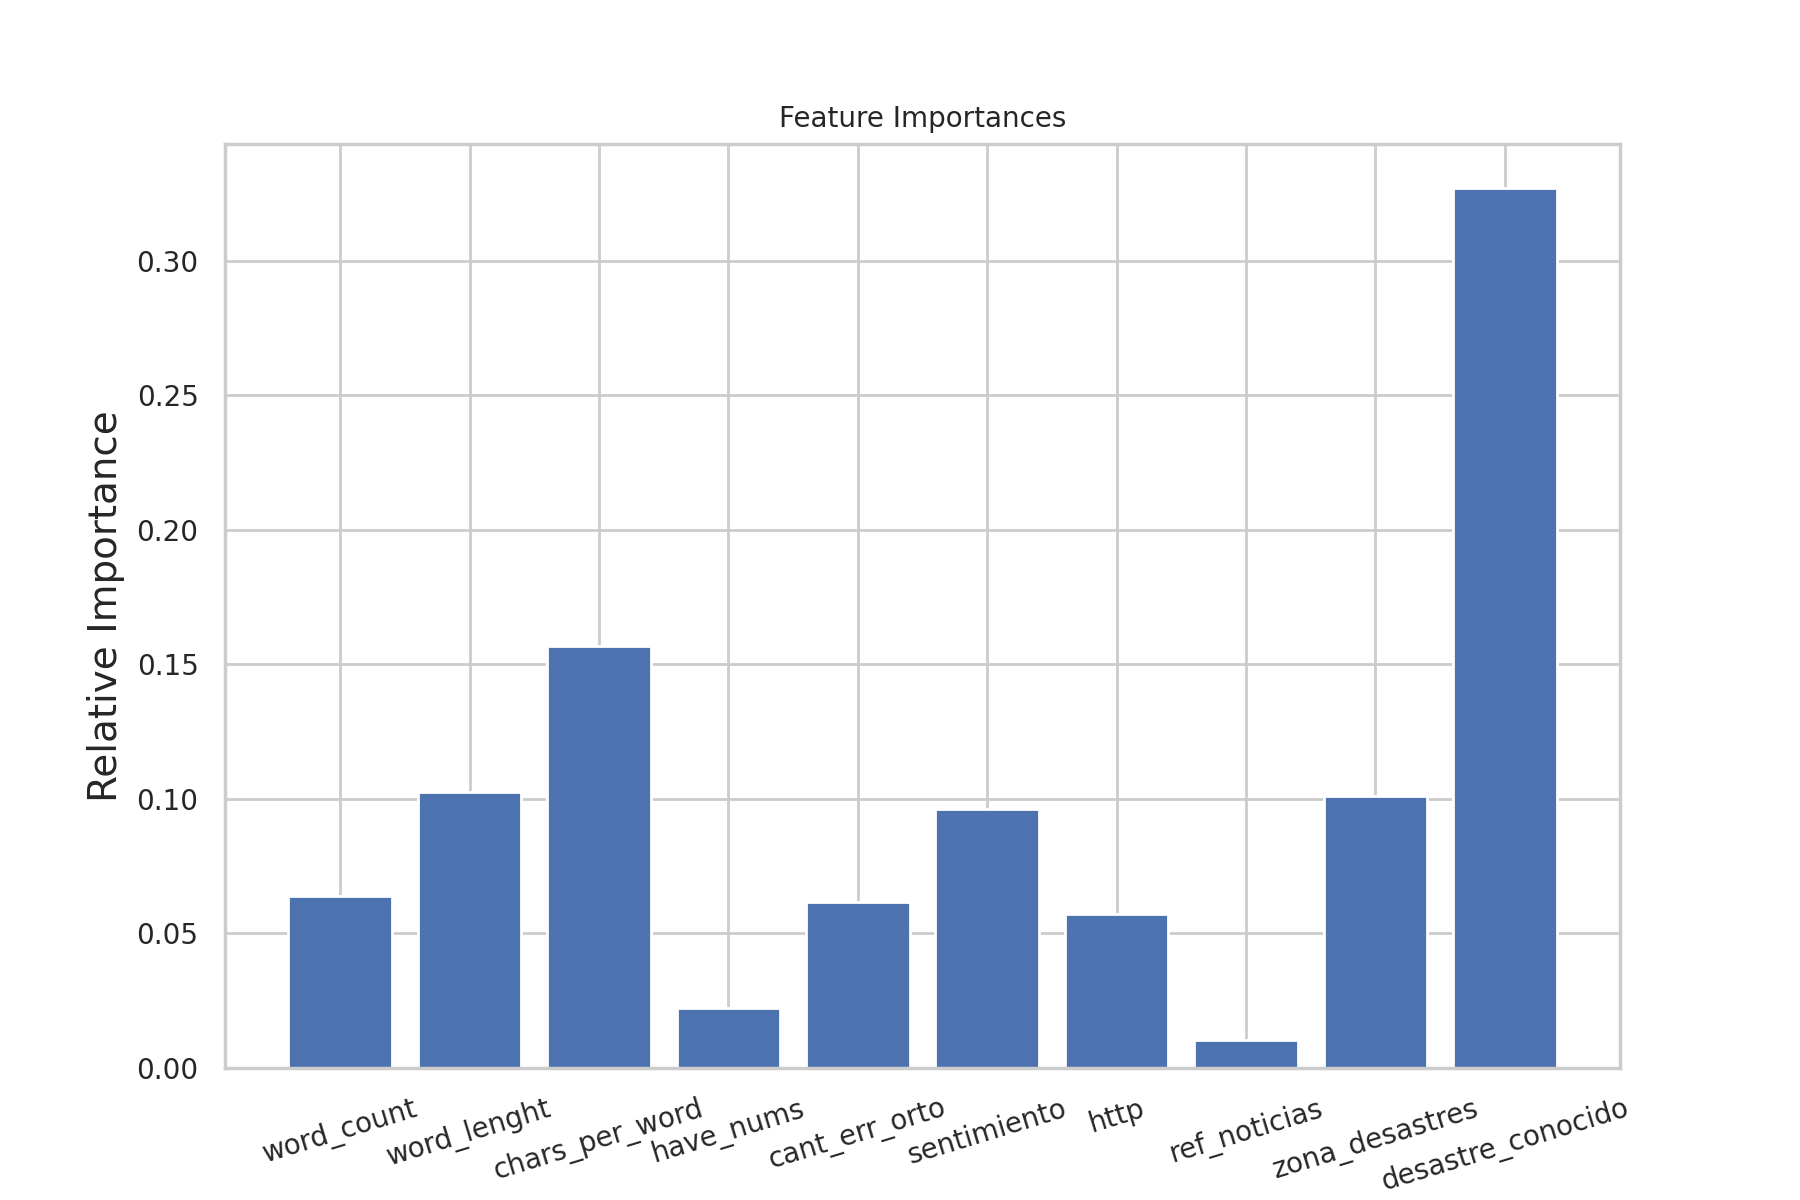

"\n\n#Tree\ntree0 = RFC.estimators_[0]\nfig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)\nplot_tree(tree0, feature_names = X_train.columns, filled = True)\nplt.show()\n\n#Buscando parámetros 'buenos'\nparam_grid = { \n    'n_estimators': [100, 500],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [3, 4,5,6,7,8],\n    'criterion' :['gini', 'entropy']\n}\n\n#Grid Search train\nGSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)\nGSCV.fit(X_train, y_train)\n\n# Best paramns\nprint(GSCV.best_params_)\n\n"

In [493]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree

    
y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
X = train_df.drop(columnas, axis=1)



#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


# Train
RFC = RandomForestClassifier(n_estimators = 300,  max_depth=8, max_features='auto',
                             criterion='entropy', random_state = 0)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)


#Features
features = np.array(X.columns)
importances = RFC.feature_importances_

#Plot
plt.figure()
plt.bar(X_train.columns, importances)
plt.title('Feature Importances')
plt.xlabel('Features')
plt.xticks(rotation=17)
plt.ylabel('Relative Importance')
plt.show()

'''

#Tree
tree0 = RFC.estimators_[0]
fig, axes = plt.subplots(nrows = 1, ncols = 1,  figsize=(9,6), dpi=200)
plot_tree(tree0, feature_names = X_train.columns, filled = True)
plt.show()

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''


# 2. Regresión Logística

In [494]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler

    
y = train_df['target']
columnas = ['id', 'keyword', 'location', 'text', 'target', 'text_sin_sw']
X = train_df.drop(columnas, axis=1)

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)


#Entrenamiento
LR = LogisticRegression(penalty='l2', max_iter=500, C=1.5, random_state = 1)
LR.fit(X_train, y_train)

#Métricas
y_pred_lr = LR.predict(X_test)
print_metrics(y_test, y_pred_lr)


Accuracy: 0.7352941176470589 F1:  0.6475524475524476 Precisión:  0.731437598736177


# 3. KNN

Accuracy: 0.7841386554621849 F1:  0.7074733096085409 Precisión:  0.8174342105263158


<IPython.core.display.Javascript object>


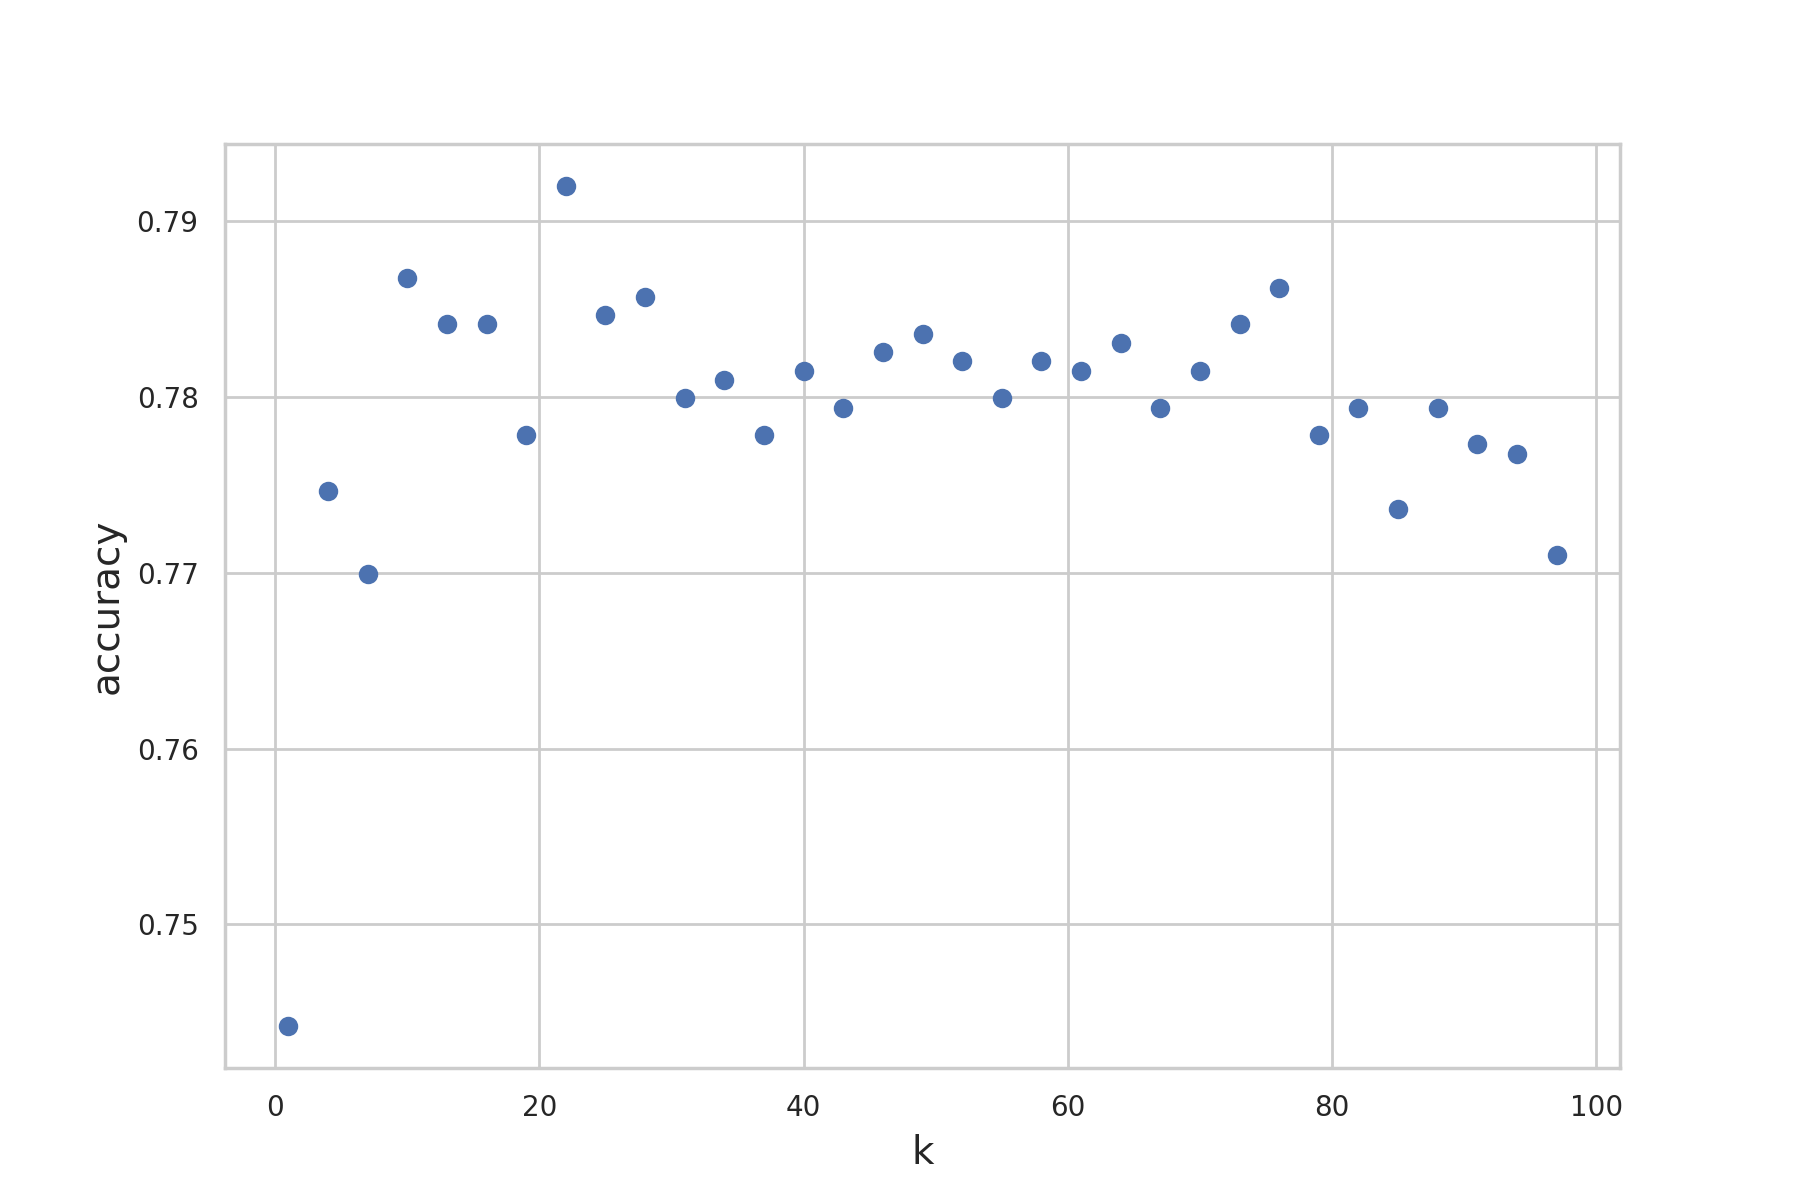

In [495]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfTransformer

X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 16)
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
print_metrics(y_test, y_pred)

#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k)
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()


# 4. Multinomial NB

In [496]:
from sklearn.naive_bayes import MultinomialNB

X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred_gnb = MNB.predict(X_test)

print_metrics(y_test, y_pred_gnb)

Accuracy: 0.8051470588235294 F1:  0.742896742896743 Precisión:  0.8297213622291022


# 5. RFC - Text

In [497]:
from sklearn.ensemble import RandomForestClassifier

X = train_df['text_sin_sw']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

# Train
RFC = RandomForestClassifier(n_estimators = 20,  n_jobs=-1, random_state = 0)
RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#metrics
print_metrics(y_test, y_pred)



Accuracy: 0.8019957983193278 F1:  0.7412491420727522 Precisión:  0.8181818181818182
